In [1]:
# imports
import numpy as np
from IPython.display import Image
import random

random.seed(300)

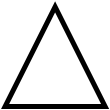

In [2]:
Image("stimuli/stim03.png")

In [3]:
# %load pomcp.py
# revisiting pomcp with the new game dynamics to compare to the real data

# pamop @nyu.edu, gureckis @gmail.com
# last edited dec 3, 2019

# imports
# from random import randint
import os
import sys
import pdb
import math
import copy
import ast
import random
import pprint
import datetime  # for limiting calculation to wall clock time
import numpy as np
import anytree as tree
from scipy import optimize
from ascii_graph import Pyasciigraph

import pandas as pd

import cProfile
import re

# # in order to import the BlockGame dynamics
# sys.path.append("..")
# from exp2.gamedynamics import BlockGame # how long has this been exp instead of exp2? feb 12 2020 ## Oh actually doesn't matter, not used in the code at all


class POMCP:
    def __init__(
        self,
        simgame, # I am not giving this one a default because you GOTTA PUT IT IN THERE or this will NO WORK
        observation=2,
        gamma=0.8,
        explore=1,
        epsilon=1e-7,
        n_particles=100,
        **kwargs,
    ):

        # general model parameters
        self.gamma = gamma  # discount factor for future rewards
        self.epsilon = epsilon  # explore for epsilon greedy
        self.explore = explore  # explore for UCB
        self.n_particles = n_particles

        # the block game we are playing
        self.simgame = simgame 
        self.target = self.simgame.target
        # self.simgame = BlockGame(self.target) # i want to try this again bc i want it to work

        self.noprint = kwargs.get("noprint", False)
        self.calculation_time = datetime.timedelta(seconds=kwargs.get("time", 5))
        # self.maxdepth = kwargs.get("maxdepth", 20)
        self.nsims = kwargs.get("nsims", 100)
        self.priors = kwargs.get("priors")

        self.choicealg = kwargs.get("choicealg", "ucb")  # "ucb" "pref" "egreedy"

        # decision tree and histories
        self.tree = tree.Node(
            "root",
            N=self.N_init(),
            V=self.V_init(),
            belief=self.B_init(self.priors, self.n_particles),
        )  # self.tree is the entire tree
        self.root = self.tree  # self.root points to the current node in the tree
        self.history = []  # history of actions and observations
        self.last_event = None  # the last action or observation made

        ## debugging variables
        self.last_simulate_rollout_q = False  # did the last simulation use rollout?
        self.max_depth_last_simulate = 0  # what was the depth of the last simulation

        # preferred actions dataframe
        try:
            self.best_actions = pd.read_csv("model/shortestpaths.csv",index_col=0)
        except: # This happens when i'm running from a jupyter notebook, paths are weird in this world *eye roll* 
            # print("you look like you're accessing this file from a jupyter notebook") 
            self.best_actions = pd.read_csv("../model/shortestpaths.csv",index_col=0)

    def print_tree_choices(self):
        pprint.pprint(self.tree.children)

    def print_root_choices(self):
        pprint.pprint(self.root.children)

    def print_root_parents(self):
        pprint.pprint(self.root.parent.children)

    def print_tree(self):
        """prints a representation of the tree to the terminal"""
        print(tree.RenderTree(self.tree, style=tree.DoubleStyle))

    def add_to_history(self, event):
        self.history += [str(event)]
        self.last_event = str(event)

    @staticmethod
    def terminal_histogram(data, bins, title="Particle Distribution"):
        """plots a hisogram of the belief vector"""
        heights, bars = np.histogram(data, bins)
        bars_chart = [(str(i), j) for i, j in zip(bars, heights)]
        graph = Pyasciigraph()
        for line in graph.graph(title, bars_chart):
            print(line)

    @staticmethod
    def string_path(path):
        """a helper function for formatting the full path to a node"""
        return "/".join([""] + [str(node.name) for node in path])

    @staticmethod
    def N_init():
        """initializes the counter of number of visits to a node"""
        return 0

    @staticmethod
    def V_init():
        """initializes the value of a node"""
        return 0.0

    # This is a little hacky because it is specific to my experiment type - the sort of prior i give subjects
    # is two states where each is equally likely. could generalize for diff types of priors
    @staticmethod
    def B_init(priors=None, n_particles=None):
        """initializes belief particle.  either empty list or sampled from a provided prior"""
        if priors is None and n_particles is None:
            return [] 
        else:
            return random.choices(priors, k=n_particles)

    @staticmethod
    def greedy_select(values):
        """chooses the maximum in values, selecting randomly if there are ties"""
        values = np.array(values)  # convert to array
        return random.choice(np.flatnonzero(values == values.max()))

    def observe(self, obs):
        """updates the model based on observation that was made"""
        self.add_to_history(obs)
        # If that observation was already simulated, choose its existing node. Otherwise create obs node
        child = [c for c in self.root.children if c.name == str(obs)]
        if not child:
            print("No obs node for what just happened, making a new one")
            obs_node = tree.Node(
                str(obs),
                parent=self.root,
                N=self.N_init(),
                V=self.V_init(),
                belief=self.B_init(),
            )
        else:
            obs_node = child[0]
        self.root = obs_node

    def choose(self):
        """asks the agent to choose which action to take"""
        completedsims = 0
        while completedsims < self.nsims:
            try:
                sampled_state = random.choice(self.root.belief)
            except IndexError:  # if no belief
                print(
                    "Encountered an error where the belief vector is empty for this current node.  Choosing randomly for now"
                )
                # print(len(self.simgame.StateNames)) # oh god it needs a -1  
                sampled_state = random.randint(0, len(self.simgame.StateNames)-1)  # WEEEOOOO WEEEOO THIS WAS SPITTING OUT 13s 2/18/20
            self.simulate(sampled_state, self.history, self.root, 0)
            completedsims += 1
            # self.explore -= 1.0 / self.nsims  # slowly decreasing explore HACKY
            if completedsims % 99 == 0 and not self.noprint:
                print(".", end="")

        childvals = np.array(
            [(idx, n.V) for idx, n in enumerate(self.root.children) if n.N > 0]
        )  # what if all are zero?

        bestkididx = POMCP.greedy_select(childvals[:, 1]) # HOW TO MAKE THIS IGNORE NON-PREF ACTIONS?
        bestkid = self.root.children[int(childvals[bestkididx, 0])]

        # update agent tree (step down to the action we actually take)
        self.root = bestkid
        # our chosen action!
        action = bestkid.name
        # update history bc we are going to take this action
        self.add_to_history(action)

        return action

    def simulate(
        self, sampled_state, current_history, parent_node, depth, force_actions=None
    ):  
        # pnode = parent action node
        if self.gamma ** depth < self.epsilon: # or depth > self.maxdepth:
            self.max_depth_last_simulate = depth
            return 0

        # print("Simulating", sampled_state)
        # if there are no action nodes, create them
        if len(parent_node.children) == 0:  # no current children - EXPAND
            # expand
            for a in self.simgame.all_actions():
                tree.Node(
                    str(a), parent=parent_node, N=self.N_init(), V=self.V_init()
                )  # action nodes don't need belief
            # act = random.choice(self.simgame.all_actions()) #RANDOM ROLLOUT
            R = self.rollout(sampled_state, depth)  # rollout
            return R

        # Are we in the final state? please end the trial for goodness' sake
        if sampled_state == self.target:
            action = "[3, 'q', 'q']"
            choice_node = [
                c for c in parent_node.children if c.name == str(action)
            ][0]
            action_array = [3, "q", "q"]
        else:
            #otherwise, we will choose one of the child actions using ucb
            # explore
            if self.choicealg == "egreedy":
                choice_node = self.e_greedy_action_selection(
                    parent_node, self.explore, sampled_state
                )
            elif self.choicealg == "ucb":
                choice_node = self.ucb_action_selection(
                    parent_node, self.explore
                )
            elif self.choicealg == "pref": 
                # add another possible action selection algorithm. only choose among the nodes that 
                # are preferred actions (e.g., shortest path to target actions + questions)
                # -- preferred actions could also end up including only "good" questions instead of all questions
                choice_node = self.pref_action_selection(
                    parent_node, self.explore, sampled_state, self.target
                )
            else: # default use UCB
                choice_node = self.ucb_action_selection(
                    parent_node, self.explore
                )
            
            action = choice_node.name
            action_array = ast.literal_eval(action)
        # end if

        # Sample a transition, observation, and reward from our generative model G
        new_state, obs, r, done = self.simgame.G_noisy(sampled_state, action_array)

        # Now we must access or create the node for the next history (current hist + action + obs)
        new_history = current_history + [str(action)] + [str(obs)]
        
        # add an observation node if needed
        child = [c for c in choice_node.children if c.name == str(obs)]
        if not child:
            obs_node = tree.Node(
                str(obs),
                parent=choice_node,
                N=self.N_init(),
                V=self.V_init(),
                belief=self.B_init(),
            )
        else:
            obs_node = child[0]

        # *** ADDING A PARTICLE TO THE CHILD NODE BELIEF STATE: HELPFUL OR PROBLEMATIC?
        # obs_node.belief.append(new_state)
        # # obs_node.N += 1
        # if len(obs_node.belief) > self.n_particles:
        #     obs_node.belief.pop(0)

        # Recurse to get total reward
        R = r + self.gamma * self.simulate(new_state,new_history,obs_node,depth+1)

        parent_node.belief.append(sampled_state) # unsure if this is a good idea anymore because it's changing the current node belief while simulating
        if len(parent_node.belief) > self.n_particles:
            parent_node.belief.pop(0)
        parent_node.N += 1

        choice_node.N += 1
        choice_node.V = choice_node.V + (R - choice_node.V) / choice_node.N # max(choice_node.V, R)

        return R

    def rollout(self, s, depth):
        if self.gamma ** depth < self.epsilon: # or depth > self.maxdepth:
            self.max_depth_last_simulate = depth
            return 0

        #in the rollout function, choose the rollout action policy
        if s==self.target:
            a = [3, "q", "q"]
            # Probably should end the game cuz you think you in the end goal state!
        else: 
            # Feb 11 reimplementing todd's pref actions
            # ask_acts = self.simgame.all_actions()[9:16]
            actions_to_target = []

            actions_to_target.append(self.retrieve_best_action(s,self.target))

            for act in self.simgame.all_actions():
                if act[0]==2: # question action
                    # implement something about only adding good questions?
                    actions_to_target.append(act)

            a = random.choice(actions_to_target)
        

        # ask the black box "what would happen if i took this action in this state?"
        s_new, o, r, done = self.simgame.G_noisy(s, a)

        # if the game is over, we have reached a terminal state and stop rolling out
        if done:
            self.max_depth_last_simulate = depth
            return r

        # CAptains log star date jan 31 ok. I'm gonna make my own new smart rollout bc i am doing it MY WAY
        # Let's start simple. if u in target state, end the game, if not, don't. 
        # if s_new == self.target:
        #     # Probably should end the game cuz you think you in the end goal state!
        #     a_new = [3, "q", "q"]
        # else: 
        #     # let us NOT choose the end game action, but check out other possibilities. 
        #     a_new = random.choice(self.simgame.all_actions()[0:16])

        # captain's log star date january 29, 2020. the heuristicy rollout below has been preventing my
        # beautiful POMCP from being able to flourish in an environment of noisy transitions. i cry.
        # i fix. (wish i could have some sort of preferred actions instead of just random rollout tho)
        # a_new = random.choice(self.simgame.all_actions())

        # THIS PART IS VERY SPECIFIC TO THE WORLD MODEL / GAME BEING PLAYED! NOT GENERAL IN THIS FORMAT!
        # next action: rollout can choose dumbly (randomly) or wisely (informed) 
        # This is different now that there is stochasticity in the problem though, because 
        # the easy heuristic of "if the simulated next state is the target then choose end action"
        # won't be 100% faithful like it was before.
        # ask_acts = self.simgame.all_actions()[9:16]
        # actions_to_target = []

        # actions_to_target.append(ask_acts)

        # if s_new == self.target:  # in parent_node.belief:
        #     # WITH transition probability known of problem,
        #     if random.random() < self.simgame.tProb:
        #         a_new = [3, "q", "q"]
        # else:
        #     for a in self.simgame.all_actions():
        #         _ns = self.simgame.next_state(s_new, a)
        #         if _ns == self.target:
        #             actions_to_target.append(a)

        # if len(actions_to_target) > 0:
        #     a_new = random.choice(actions_to_target)
        # else:
        #     a_new = random.choice(self.simgame.all_actions()) # any of the blockgame actionssssss

        #     # rollout policy could be wiser - only questions, or only legal actions
        return r + self.gamma * self.rollout(s_new, depth + 1)

    def retrieve_best_action(self,state,target):
        a = self.best_actions.loc[state,str(target)]
        # try:
            
        # except:
        #     print("i tried to call best actions on state " + str(state) + " and target " + str(target))
        return ast.literal_eval(a) #pandas is annoying

    def pref_action_selection(self, parent, explore, state, target):
        # prune the tree - only choose between select child nodes. --> choose greedily or UCB among child nodes? let's try ucb'
        # use "retrieve best action" method to select the shortest path move action
        # then add the "ask" actions as well and then do UCB over them

        moveact = self.retrieve_best_action(state, target)
        prefchildren = [child for child in parent.children if ast.literal_eval(child.name)[0]>1 or ast.literal_eval(child.name)==moveact]

        # now do ucb over the children
        sumn = np.array([c.N for c in prefchildren]).sum()
        vals = [ UCB(parent.N + 1, c.N + 1, c.V, explore) for c in prefchildren]
        choice = self.greedy_select(vals)

        # could also choose randomly over the children instead

        return prefchildren[choice]

    @staticmethod
    def ucb_action_selection(parent, explore):

        sumn = np.array([child.N for child in parent.children]).sum()

        vals = [ UCB(parent.N + 1, child.N + 1, child.V, explore) for child in parent.children
        ]
        # print("\tUCB", vals)
        choice = POMCP.greedy_select(vals)
        return parent.children[choice]


    @staticmethod
    def e_greedy_action_selection(parent, explore, current_state):
        # nodes = [c for c in parent.children if (BlockGame.next_state(current_state, ast.literal_eval(c.name))!=current_state or c.name[1]=='2')]
        nodes = parent.children[:]
        if random.random() < explore:
            # randomly select
            return random.choice(nodes)
        else:
            # choose best
            vals = [n.V for n in nodes]
            choice = POMCP.greedy_select(vals)
            return nodes[choice]



#UCB score calculation from George Pik pomcp code
def UCB(N,n,V,c = 1): #N=Total, n= local, V = value, c = parameter
    return V + c*np.sqrt(np.log(N)/n)





In [4]:
# category learning task parameters
nDimensions = 3
nProblemTypes = 6
nStimuli = 8

dimensions = list(range(0,nDimensions))
sizes = [0,1] # large, small
shapes = [0,1] # square, triangle
colors = [0,1] # black, white
problemTypes = list(range(0,nProblemTypes))
stimuli = list(range(0,nStimuli))



In [5]:
# Problem types

#Returns 0 for category A, 1 for category B
def checkStimulusCategory(problemType,stim):
    if problemType==0:
        # Shepard type I
        # 0  0 0 0 - 0
        # 1  0 0 1 - 1
        # 2  0 1 0 - 0
        # 3  0 1 1 - 1
        # 4  1 0 0 - 0
        # 5  1 0 1 - 1
        # 6  1 1 0 - 0
        # 7  1 1 1 - 1
        return stim % 2
    elif problemType==1: # Shepard type II
        labels = [0,1,1,0,0,1,1,0]
        return(labels[stim])
    elif problemType==2: # Shepard type III
        labels = [1,0,1,0,1,1,0,0]
        return(labels[stim])
    elif problemType==3: # Shepard type IV
        labels = [1,1,1,0,1,0,0,0]
        return(labels[stim])
    elif problemType==4: # Shepard type V
        labels = [1,0,1,0,1,0,0,1]
        return(labels[stim])
    elif problemType==5: # Shepard type VI
        labels = [1,0,0,1,0,1,1,0]
        return(labels[stim])
    else:
        raise ValueError("problem type must be between 0 and 5 inclusive")



In [6]:
# Defined as a POMDP
nStates = 70

states = list(range(0,nStates))

In [7]:
nTrials = 32
problemType = 0 # between 0 and 5, or could randomly choose

# randomly assign size, shape, and color to x y and z axes. Randomly assign sm/lg sq/tr bl/wh to 0 1. 
dimOrder = [0,1,2] #random.sample(dimensions,nDimensions)
sizeOrder = [0,1] #random.sample(sizes,len(sizes))
shapeOrder = [0,1] #random.sample(shapes,len(shapes))
colorOrder = [0,1] #random.sample(colors,len(colors))

stimuliFiles = ["stimuli/stim00.png",
               "stimuli/stim01.png",
               "stimuli/stim02.png",
               "stimuli/stim03.png",
               "stimuli/stim04.png",
               "stimuli/stim05.png",
               "stimuli/stim06.png",
               "stimuli/stim07.png"]

agentCorrectPercent = 0.8
options = ['A','B']

for i in range(nTrials):
    #display stimulus
    stim = random.choice(stimuli)
    Image(stimuliFiles[stim])
    
    print("A or B?")
    correctResp = checkStimulusCategory(problemType,stim)
    print("(Note: correct response is " + options[correctResp] + ")")
    
    #get response
    if random.random()<agentCorrectPercent:
        resp = correctResp
    else:
        resp = 1 - correctResp
        
    
    print("agent responded " + options[resp])
        
    #move to next trial
    input('press enter to continue')


A or B?
(Note: correct response is B)
agent responded B
press enter to continue
A or B?
(Note: correct response is A)
agent responded A
press enter to continue
A or B?
(Note: correct response is A)
agent responded A
press enter to continue
A or B?
(Note: correct response is A)
agent responded A
press enter to continue
A or B?
(Note: correct response is A)
agent responded A
press enter to continue
A or B?
(Note: correct response is A)
agent responded A
press enter to continue
A or B?
(Note: correct response is B)
agent responded A
press enter to continue
A or B?
(Note: correct response is A)
agent responded A
press enter to continue
A or B?
(Note: correct response is A)
agent responded A
press enter to continue
A or B?
(Note: correct response is B)
agent responded A
press enter to continue
A or B?
(Note: correct response is A)
agent responded A
press enter to continue
A or B?
(Note: correct response is A)
agent responded A
press enter to continue
A or B?
(Note: correct response is B)
ag

In [100]:
a = [0,1]
b = [1,0]

random.shuffle(a) #random.choice([[0,1],[1,0]])
sizes = random.sample(b, len(b))


[1, 0]

In [103]:
random.random()

0.597695785436328

In [4]:
import time
for a in range(100):
    print(a)
    time.sleep(3)


0
1


KeyboardInterrupt: 

In [ ]:
nTestTrials = 8 # IMPORTANT!! !IF THIS NUMBER CHANGES, CODE BELOW NEEDS TO CHANGE
        nHits=0

        for record in user_data['data']: # for line in data file
            trial = record['trialdata'] # get part of line holding trial info
            if trial['phase'] == 'test':
                if trial['hitormiss'] == True:
                    nHits+=1

        incentive = trial['incentive'] #number of points for above chance correct responses
        maxreward = 10.00

        # point multiplier is based on subject performance above chance
        if nHits <= 4: # if subject got at or less than half correct, at or worse than chance
            pointMult=0
        else:
            pointMult=nHits-4

        # incentive level times point multiplier
        if incentive==0:
            bonus_prob = 0
        else:
            n = np.log2(incentive)
            maxprob = 1/(2**5-n)
            bonus_prob = maxprob * pointMult/4

        #use probability to calculate whether they get $10 by pulling a random number between 0 and 1
        if np.random.random() < bonus_prob: # NOTE: if i show them this during task, np.random will be called before and the number saved to data
            reward=10.00
        else:
            reward=0.00

        user.bonus = reward